<h1 align='center' style="color: blue;">Image Recognition of Clothes</h1>

I worked on a popular Fashion MNIST dataset for this project. The dataset includes tiny images of fashion pieces. The objective is to create a set of supervised learning models that can predict the type of item based on its image. I used all different models that you learned about them in this course for yourr work. 

In order to load the dataset you need to have `tensorflow V2` on your computer. Use the following code to install the package

In [ ]:
# !pip3 install tensorflow --ignore-installed --user

You can also check the version of it using the following code.

In [1]:
import tensorflow as tf
tf.__version__

'2.10.0'

Now, it's time to load the dataset

In [2]:
from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

As can be seen from the above code, the dataset was divided into train and test sets. Let's take a look at the X_train

In [3]:
X_train.shape

(60000, 28, 28)

As it is clear, the train dataset (`X_train`) contains 60,000 images of size 28 x 28. We can visualize one of the images using the following code:

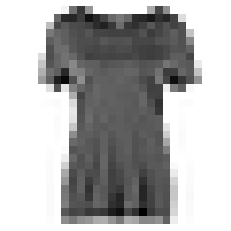

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sample_image = X_train[10]
plt.imshow(sample_image, cmap='binary')
plt.axis('off')
plt.show()

The `y_train` also includes values between 0 and 9. Each represents a particular category. For example, we can check the value of `y_train` for the above image.

In [5]:
y_train[10]

0

The above code shows that the image belongs to category 0. To get the associated label with each category, you can use the following code:

In [6]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
print(class_names[y_train[10]])

T-shirt/top


## Task 1

### Preprocessing

<p> Reshaping the dataset to 2D array

In [7]:
#Reshaping and checking shape of train and test
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]) / 255.0
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]) / 255.0

In [8]:
X_train.shape

(60000, 784)

In [9]:
X_test.shape

(10000, 784)

In [10]:
y_train.shape

(60000,)

In [11]:
y_test.shape

(10000,)

#### Importing required libraries

In [42]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
sns.set(font_scale=2)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

### PCA for Dimensionality reduction

<p>Dimensionality reduction is way to reduce the complexity of a model and avoid overfitting. There are two main categories of dimensionality reduction: feature selection and feature extraction. Via feature selection, we select a subset of the original features, whereas in feature extraction, we derive information from the feature set to construct a new feature subspace.</p>

<p>Principal Component Analysis (PCA) algorithm used to compress a dataset onto a lower-dimensional feature subspace with the goal of maintaining most of the relevant information.</p>



<p>Refering to this article about choosing no. of components for PCA</p>
<a>https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/</a>

#### Scacling data between 0 and 1 before using PCA

In [14]:
scaler = MinMaxScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.fit_transform(X_test)

#### Choosing the no. of components for PCA with 95% threshold

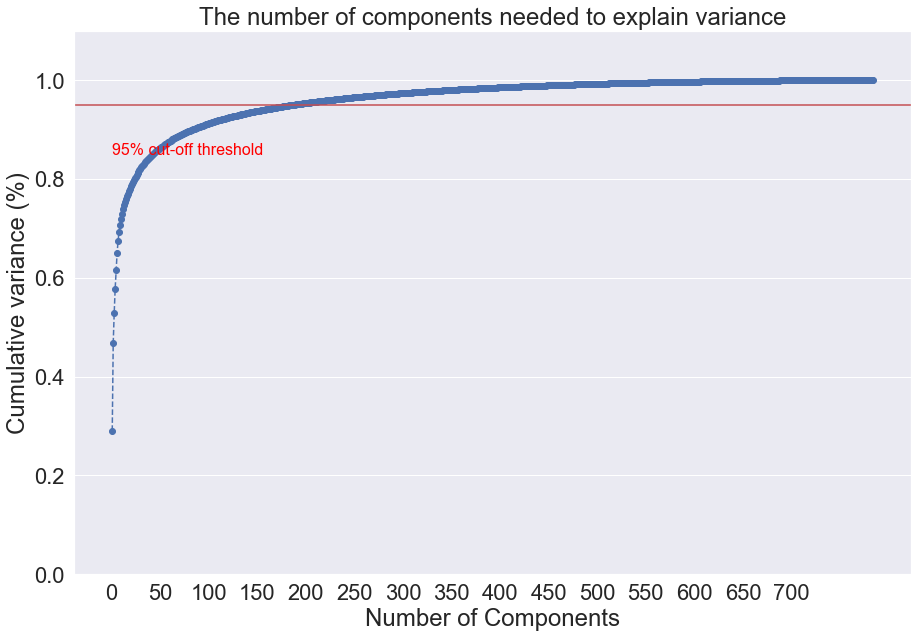

In [15]:
pca = PCA().fit(X_train_rescaled)

plt.rcParams["figure.figsize"] = (15,10)

fig, ax = plt.subplots()
xi = np.arange(1, 785, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

#plotting the data
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

#putting necessary labels
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 750, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

<p> We will choose the no of components as 200 </p>

In [16]:
pca = PCA(svd_solver='randomized', n_components=200, whiten=True, random_state=0)
#fitting and transforming X train and X test dats
X_train =pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## 1. Logistic Regression

<p>Logistic regression is used to model data and to explain the relationship between one binary dependent variable and one or more quantities.</p>

<div style='text-align:center'>$\hat{y} = \dfrac{1}{1+e^{-z}} , \hat{z} = \beta_0 + \beta_0 X_1 + \beta_2 X_2 + ... + \beta_m X_m $ </div>
<br>
<br>
<div style='text-align:center'>$prob(y^{(i)} = 1 | X^{(i)}) = \dfrac{1}{1+e^{-z^{(i)}}} , z^{(i)} = \beta_0 + \beta_0 X_1^{(i)} + \beta_2 X_2^{(i)} + ... + \beta_m X_m^{(i)} $ </div>

<p> There are several solver algorithm options in the sklearn package which are described below </p>

- newton-cg — A newton method. Newton methods use an exact Hessian matrix. It's slow for large datasets, because it computes the second derivatives.
- lbfgs — Stands for Limited-memory Broyden–Fletcher–Goldfarb–Shanno. It approximates the second derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets. It will be the default solver as of Scikit-learn version 0.22.0.
- liblinear — Library for Large Linear Classification. Uses a coordinate descent algorithm. Coordinate descent is based on minimizing a multivariate function by solving univariate optimization problems in a loop. In other words, it moves toward the minimum in one direction at a time. It is the default solver for Scikit-learn versions earlier than 0.22.0. It performs pretty well with high dimensionality. It does have a number of drawbacks. It can get stuck, is unable to run in parallel, and can only solve multi-class logistic regression with one-vs.-rest.
- sag — Stochastic Average Gradient descent. A variation of gradient descent and incremental aggregated gradient approaches that uses a random sample of previous gradient values. Fast for big datasets.
- saga — Extension of sag that also allows for L1 regularization. Should generally train faster than sag.

<p> In this task, we are using the liblinear solver

In [17]:
#modeling liblinear solver logistic regression
lr = LogisticRegression(max_iter=200, solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(max_iter=200, solver='liblinear')

### Prediction

In [18]:
y_test_hat = lr.predict(X_test)
y_train_hat = lr.predict(X_train)

### Evaluating Logistic Regression

In [19]:
lr_test_acc = accuracy_score(y_test,y_test_hat, normalize = True) * 100
lr_train_acc = accuracy_score(y_train,y_train_hat, normalize = True) * 100
print(f'Accuracy Score out of sample = {lr_test_acc}')
print(f'Accuracy Score in sample = {lr_train_acc}')

Accuracy Score out of sample = 84.04
Accuracy Score in sample = 85.97333333333333


Text(0.5, 1.0, 'Confusion Matrix')

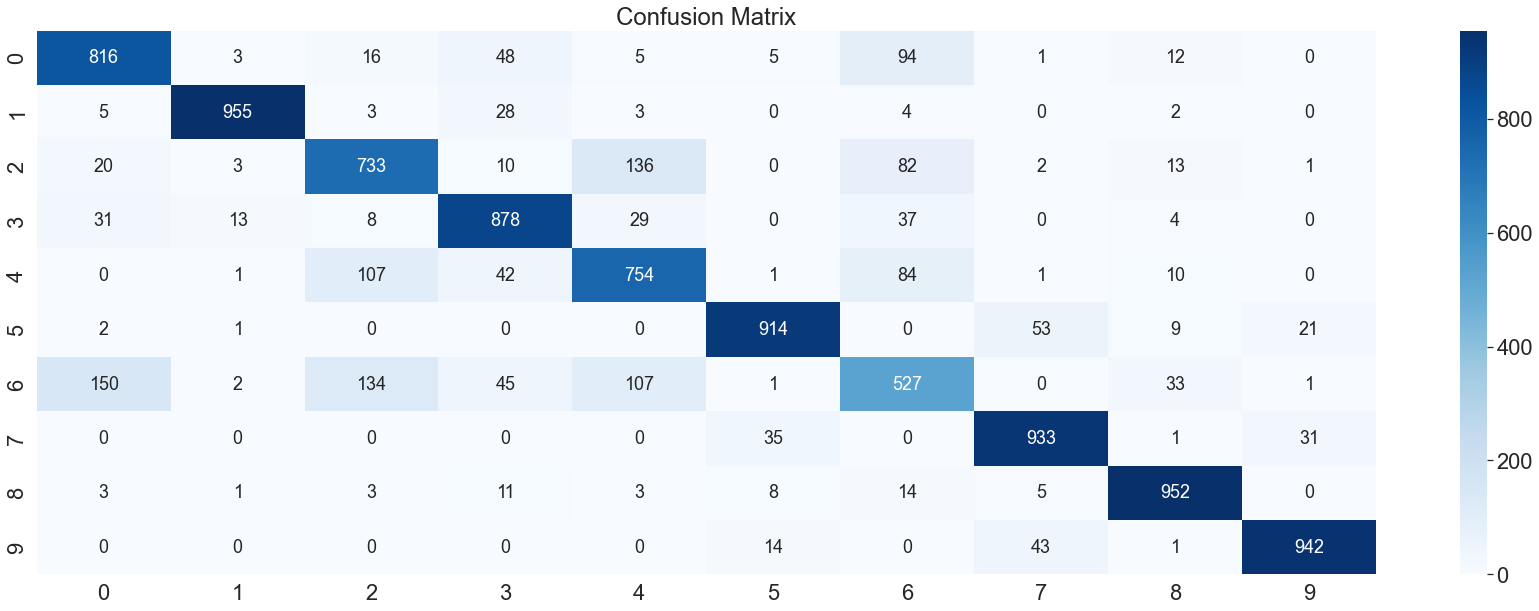

In [20]:
#plotting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_test_hat)
fig, ax = plt.subplots(figsize=(30,10))
sns.heatmap(cf_matrix, annot=True, ax=ax, fmt='g', annot_kws={'size': 18}, cmap="Blues")
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Classification Report')

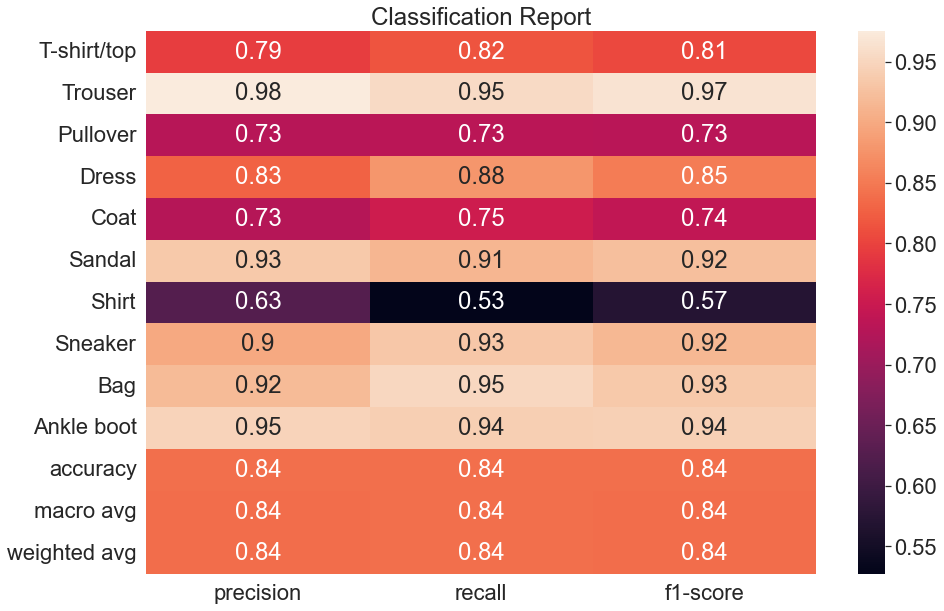

In [21]:
#plotting heat map
labels = np.arange(10)
target_names = class_names
clf_report = classification_report(y_test,
                                   y_test_hat,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

fig, ax = plt.subplots()

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=ax)
ax.set_title('Classification Report')

In [68]:
#fetching accuracy score
lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test), multi_class='ovr') 
print("AUC for logreg: {:.3f}".format(lr_auc))

AUC for logreg: 0.980


## 2. Support Vector Machines (SVM)

<p>The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.</p>

<p>We are using non-linear classification here</p>

In [28]:
# Initialize SVC model
svc = SVC(kernel='rbf',  class_weight='balanced')
# Create pipleline model
model = make_pipeline(pca, svc)

### Using Stratified Cross Validation and Grid Search to tune hyperparameters

In [ ]:
cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
param_grid = {'svc__C': [.1, 1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv = cv, scoring='accuracy')
%time grid.fit(X_train, y_train)
print(grid.best_params_)

## 3. Random Forest Classifier

<p>Using optimized ensemble of randomized decision trees that is implemented in the RandomForestClassifier estimator, which takes care of all the randomization automatically.</p>

In [45]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

### Prediction

In [46]:
y_train_hat  = rf.predict(X_train)
y_test_hat  = rf.predict(X_test)

### Evaluate Random Forest Classifier

In [47]:
rf_test_acc = accuracy_score(y_test,y_test_hat, normalize = True) * 100
rf_train_acc = accuracy_score(y_train,y_train_hat, normalize = True) * 100
print(f'Accuracy Score out of sample = {rf_test_acc}')
print(f'Accuracy Score in sample = {rf_train_acc}')

Accuracy Score out of sample = 85.86
Accuracy Score in sample = 100.0


Text(0.5, 1.0, 'Confusion Matrix')

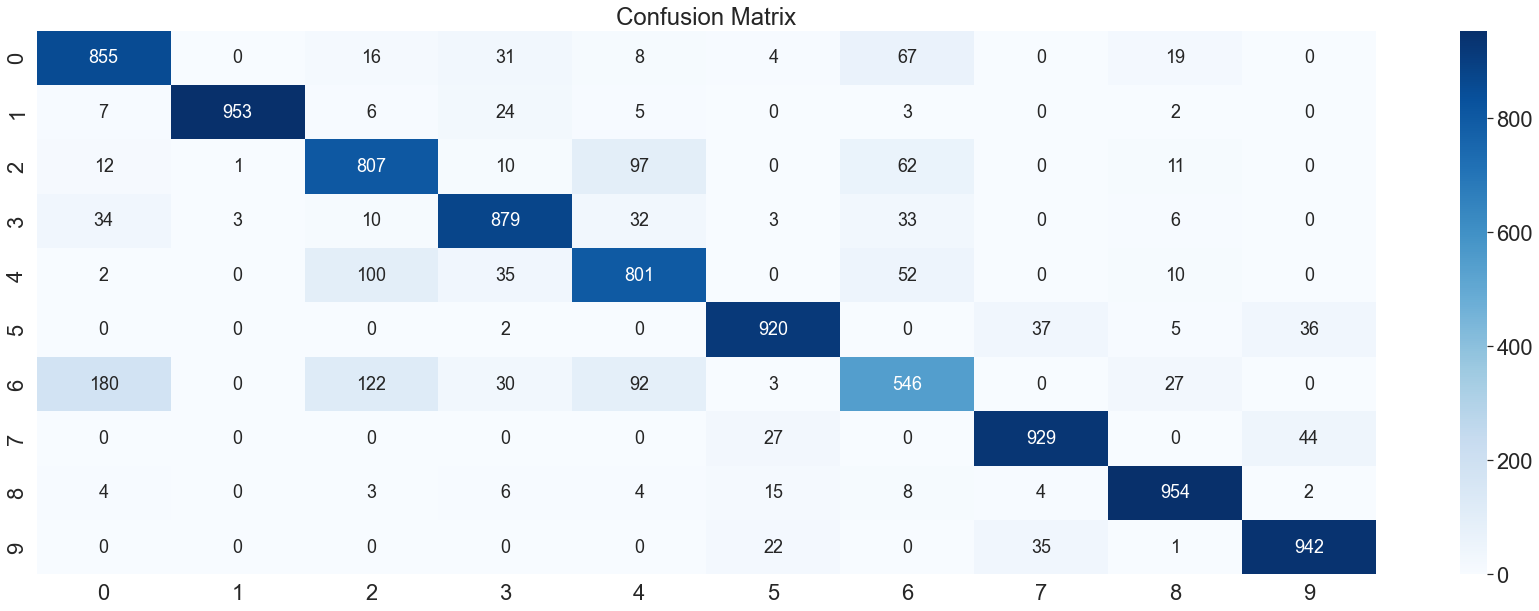

In [48]:
cf_matrix = confusion_matrix(y_test, y_test_hat)
fig, ax = plt.subplots(figsize=(30,10))
sns.heatmap(cf_matrix, annot=True, ax=ax, fmt='g', annot_kws={'size': 18}, cmap="Blues")
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Classification Report')

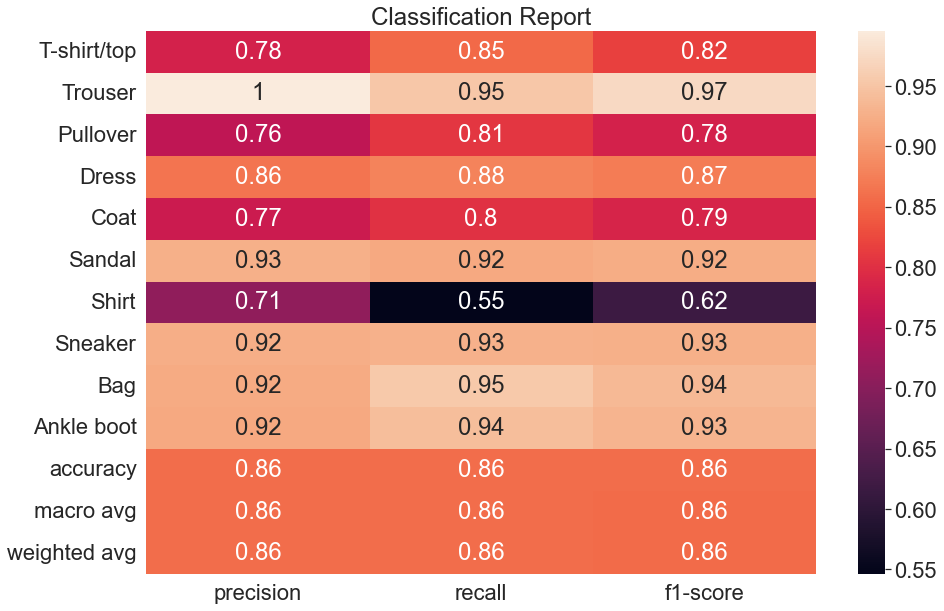

In [49]:
labels = np.arange(10)
target_names = class_names
clf_report = classification_report(y_test,
                                   y_test_hat,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

fig, ax = plt.subplots()

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=ax)
ax.set_title('Classification Report')

In [72]:
#fetching accuracy score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr') 
print("AUC for Random forest: {:.3f}".format(rf_auc))

AUC for Random forest: 0.987


## 4. XGBoost

In [51]:
xgb = XGBClassifier(use_label_encoder=False,objective="multi:softproba",eval_metric="merror")
xgb.fit(X_train, y_train.ravel())

C:\Users\vishn\anaconda3\envs\pranati\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

### Prediction

In [80]:
y_train_hat  = xgb.predict(X_train)
y_test_hat  = xgb.predict(X_test)

### Evaluate XGBoost

In [81]:
xgb_test_acc = accuracy_score(y_test,y_test_hat, normalize = True) * 100
xgb_train_acc = accuracy_score(y_train,y_train_hat, normalize = True) * 100
print(f'Accuracy Score out of sample = {xgb_test_acc}')
print(f'Accuracy Score in sample = {xgb_train_acc}')

Accuracy Score out of sample = 87.52
Accuracy Score in sample = 99.94


Text(0.5, 1.0, 'Confusion Matrix')

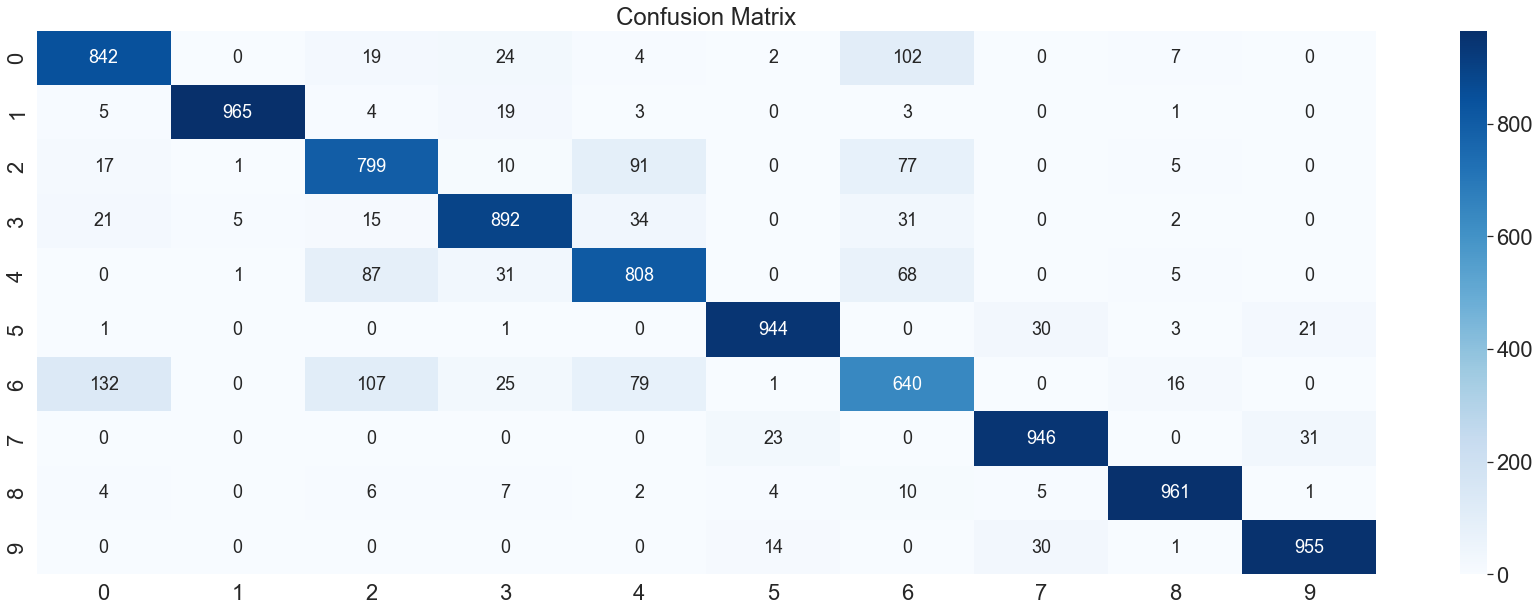

In [82]:
cf_matrix = confusion_matrix(y_test, y_test_hat)
fig, ax = plt.subplots(figsize=(30,10))
sns.heatmap(cf_matrix, annot=True, ax=ax, fmt='g', annot_kws={'size': 18}, cmap="Blues")
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Classification Report')

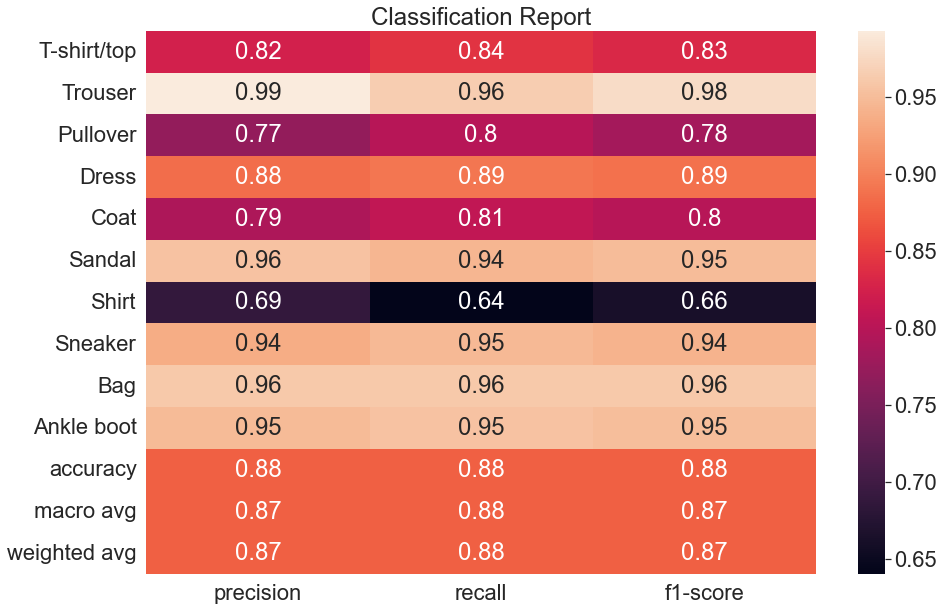

In [83]:
labels = np.arange(10)
target_names = class_names
clf_report = classification_report(y_test,
                                   y_test_hat,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

fig, ax = plt.subplots()

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=ax)
ax.set_title('Classification Report')

In [71]:
#fetching accuracy score of XGBoost
xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test), multi_class='ovr') 
print("AUC for XGBoost: {:.3f}".format(xgb_auc))

AUC for XGBoost: 0.990


## 5. Neural Networks

In [62]:
mlp = MLPClassifier(solver='lbfgs',random_state=0)
mlp.fit(X_train,y_train)

MLPClassifier(random_state=0, solver='lbfgs')

### Prediction

In [84]:
y_train_hat  = mlp.predict(X_train)
y_test_hat  = mlp.predict(X_test)

### Evaluating MLP Classifier

In [85]:
mlp_test_acc = accuracy_score(y_test,y_test_hat, normalize = True) * 100
mlp_train_acc = accuracy_score(y_train,y_train_hat, normalize = True) * 100
print(f'Accuracy Score out of sample = {mlp_test_acc}')
print(f'Accuracy Score in sample = {mlp_train_acc}')

Accuracy Score out of sample = 85.58
Accuracy Score in sample = 100.0


Text(0.5, 1.0, 'Confusion Matrix')

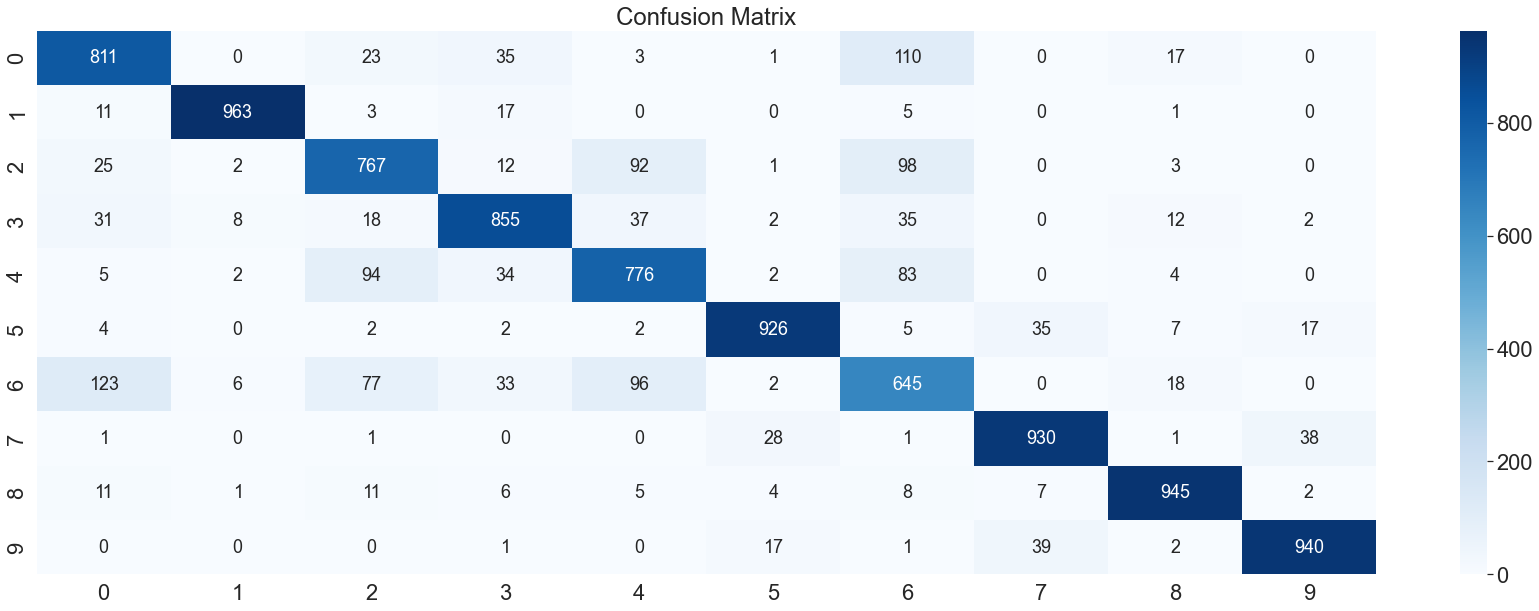

In [86]:
cf_matrix = confusion_matrix(y_test, y_test_hat)
fig, ax = plt.subplots(figsize=(30,10))
sns.heatmap(cf_matrix, annot=True, ax=ax, fmt='g', annot_kws={'size': 18}, cmap="Blues")
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Classification Report')

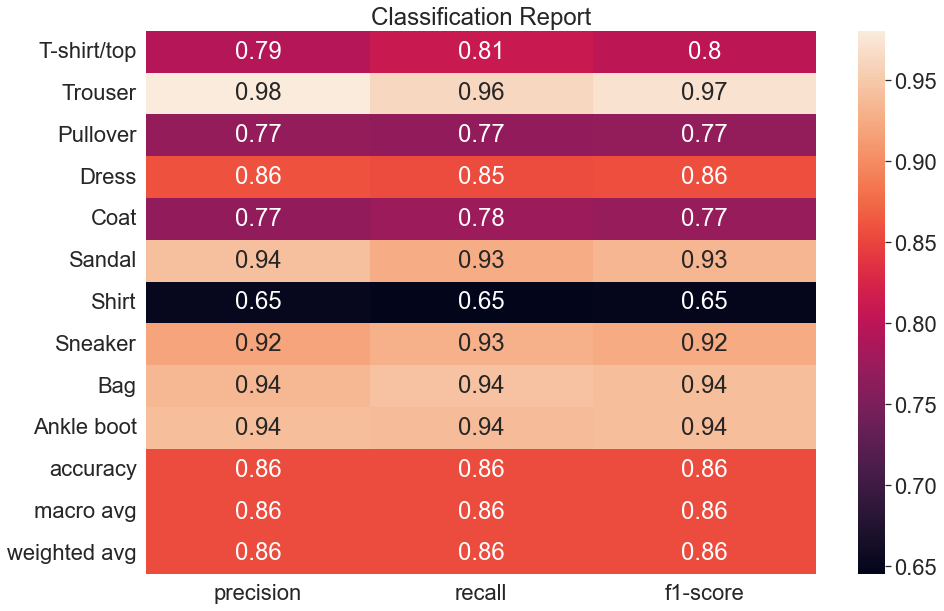

In [87]:
labels = np.arange(10)
target_names = class_names
clf_report = classification_report(y_test,
                                   y_test_hat,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

fig, ax = plt.subplots()

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=ax)
ax.set_title('Classification Report')

In [74]:
mlp_auc = roc_auc_score(y_test, mlp.predict_proba(X_test), multi_class='ovr') 
print("AUC for MLP: {:.3f}".format(mlp_auc))

AUC for MLP: 0.985


### Comparing the models

#### Accuracy score

In [78]:
data = {
         'Model': ['Logistic Regression', 'Random Forest Classifier', 'XGBoost', 'Neural Network'],
         'Train Accuracy': [lr_train_acc, rf_train_acc, xgb_train_acc, mlp_train_acc],
         'Test Accuracy': [lr_test_acc, rf_test_acc, xgb_test_acc, mlp_test_acc],
         'AUC Score': [lr_auc*100, rf_auc*100, xgb_auc*100, mlp_auc*100]
       }

scores_df = pd.DataFrame(data)
scores_df

,Model,Train Accuracy,Test Accuracy,AUC Score
0,Logistic Regression,85.973333,84.04,98.004258
1,Random Forest Classifier,100.000000,85.86,98.658515
2,XGBoost,99.940000,87.52,98.993729
3,Neural Network,100.000000,85.58,98.480310


<AxesSubplot:xlabel='Model'>

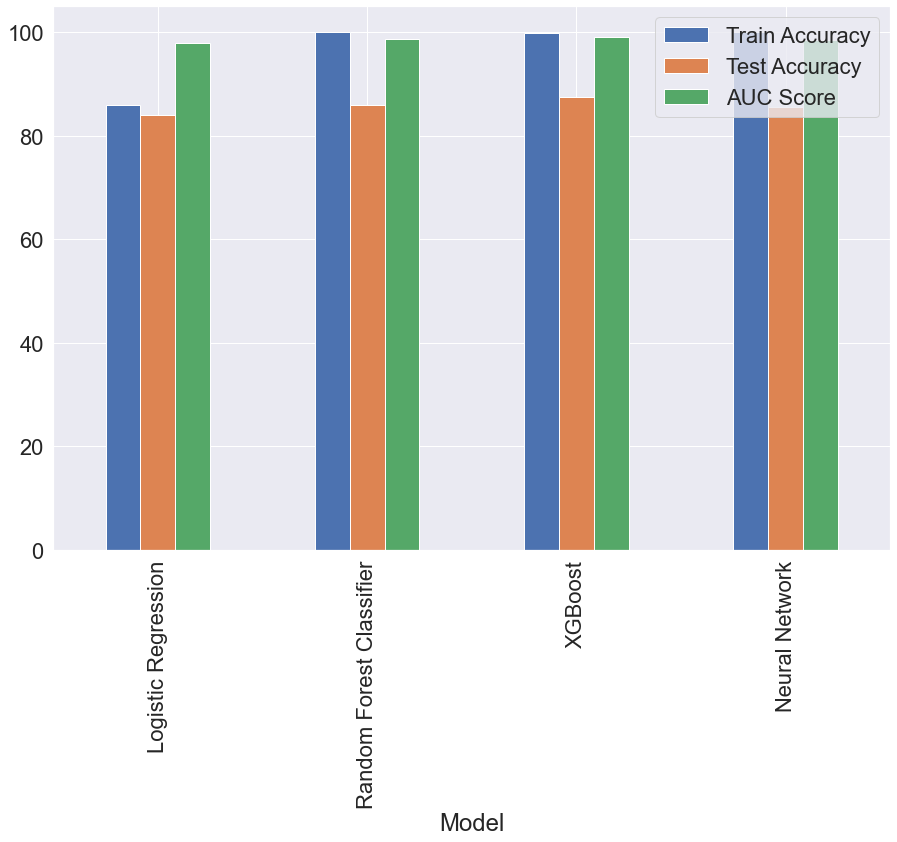

In [79]:
scores_df.plot(x='Model', y=['Train Accuracy', 'Test Accuracy', 'AUC Score'], kind='bar')

<p> Based on Accuracy score we can observe that XGBoost performs the best with an out of sample data accuracy score of 87.52 </p>

<p> However it is also important to observe the AUC for the following reasons </p>
- AUC represents the probability that a random positive (green) example is positioned to the right of a random negative (red) example.

- AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.
- AUC is desirable for the following two reasons:
- AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
- AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

<p> XGBoost has the highest AUC at 0.990 </p>

### XGBoost is the best model based on the Accuracy and AUC

## Task 2

### Pictures of five items

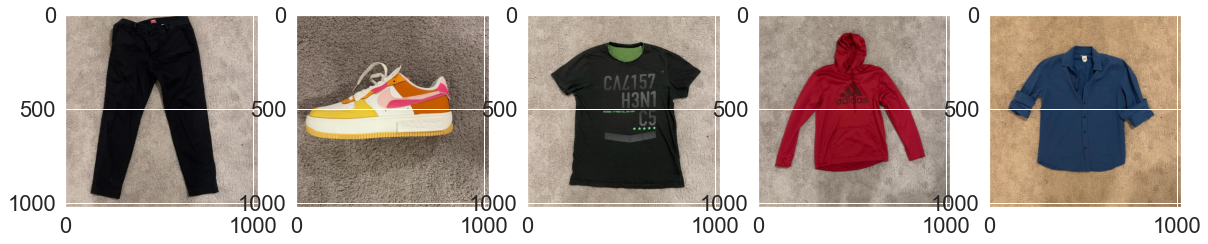

In [92]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('photos/*.jpeg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) // columns + 1, columns, i + 1)
    plt.imshow(image)

### Resizing the images to 28x28 and convert to grayscale

C:\Users\vishn\AppData\Local\Temp\ipykernel_4120\4043008772.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_28x28 = np.array(img_pil.resize((28, 28), Image.ANTIALIAS))


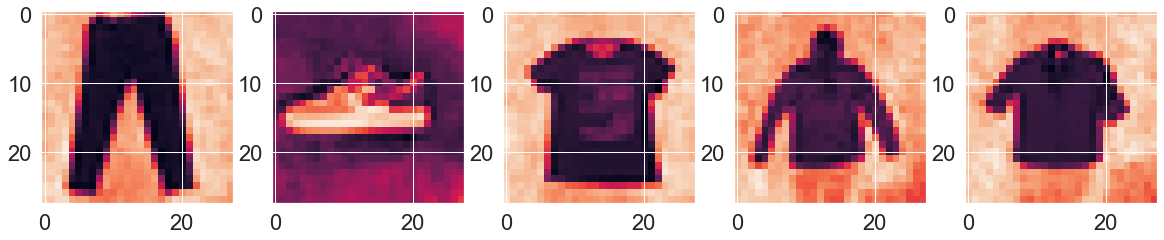

In [132]:
import numpy as np
from PIL import Image
import cv2
import os

IMG_DIR = 'photos'

photos = []

for img in os.listdir(IMG_DIR):
    img_array = cv2.imread(os.path.join(IMG_DIR,img), cv2.IMREAD_GRAYSCALE)

    img_pil = Image.fromarray(img_array)
    img_28x28 = np.array(img_pil.resize((28, 28), Image.ANTIALIAS))
    photos.append(img_28x28)

images = np.array(photos)

# Displaying the images side by side
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) // columns + 1, columns, i + 1)
    plt.imshow(image)

In [135]:
images = images.reshape(images.shape[0], images.shape[1] * images.shape[2]) / 255.0
scaler = MinMaxScaler()
images = scaler.fit_transform(images)
images = pca.transform(images)

y_pred = xgb.predict(images)
y_pred

array([1, 9, 0, 2, 2])

In [136]:
y_actual_names = ['Trouser', 'Sneaker', 'T-shirt/top', 'Pullover', 'Shirt']
y_true = [1, 7, 0, 2, 6]

### Results

- The model was able to predict Trouser, Sneaker and Tshirt correctly
- The model predicted sneaker as ankle boot and shirt as pullover possibly due the close similarity
- The accuracy of the model is 60%